**Assignment: Zero-Crossing Rate**

count how many times the signal goes from positive to negative, and from negative to positive.

*Possible approach:*

Shift the signal by one unit
Compare point-by-point the sign (np.sign()) of the original signal and of the shifted signal
Accumulate the instances of sign change




In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

In [2]:
copyfile('/content/drive/MyDrive/Digital signal and image management/recordings (1).tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()
# Import file
sound_rate, sound_data = wav.read('recordings/0_jackson_0.wav')
# Play the signal
ipd.Audio(sound_data, rate=sound_rate)

1- COMPUTE ZCR
The function np.sign() returns an array of values 1,0 and -1, for every pair of consecutive values in the array np.diff() calculate the difference. A change in sign indicates a zero crossing. The measure computed is relative

In [7]:
def computezcr(signal):
    sign_changes = np.sign(signal)
    zero_crossings = np.diff(sign_changes)
    zcr = np.sum(zero_crossings != 0) / len(signal)
    return np.array([zcr])

In [8]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test


2- TRAIN Support VectorMachine Classifier using ZCR


Number of training examples: 1350
Dimensionality of the training features: (1,)


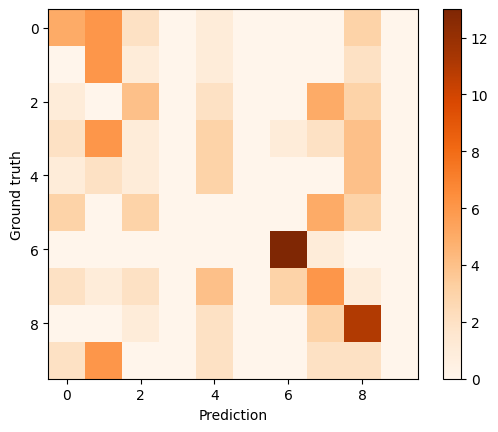

In [9]:
# Data loading with ZCR feature
X_train, X_test, y_train, y_test = load_data(feature_extractor=computezcr, normalize=True)

# Stampa informazioni sui dati caricati
print('Number of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(np.array(X_train[0]).shape))



# SVM initialization and training
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)

# SVM test
y_pred = clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Oranges)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.colorbar()
plt.show()


In [10]:
# Classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.31      0.29      0.30        17
           1       0.22      0.60      0.32        10
           2       0.27      0.27      0.27        15
           3       0.00      0.00      0.00        19
           4       0.17      0.27      0.21        11
           5       0.00      0.00      0.00        14
           6       0.76      0.93      0.84        14
           7       0.25      0.32      0.28        19
           8       0.33      0.65      0.44        17
           9       0.00      0.00      0.00        14

    accuracy                           0.32       150
   macro avg       0.23      0.33      0.27       150
weighted avg       0.23      0.32      0.26       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model correctly predicts 32% of the instances, which is low. The model fails to identify Class 9,3 and 5.

**COMBO** Energy, Duration and Zero Crossing Rate

In [11]:
# ENERGY
def energy(signal):
    return np.sum((signal*1.0)**2, keepdims=True)

In [12]:
def duration(signal):
    return np.array(signal.shape)

In [13]:
def combo2(signal):
    return np.concatenate((energy(signal),duration(signal),computezcr(signal)))

In [14]:

X_train, X_test, y_train, y_test = load_data(feature_extractor=combo2, normalize=True)


print('Number of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(np.array(X_train[0]).shape))




Number of training examples: 1350
Dimensionality of the training features: (3,)


In [15]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Training completed in 8.448s
Best parameters combination:
 C: 100
 gamma: 0.5


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [16]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.59      0.62        17
           1       0.35      0.70      0.47        10
           2       0.44      0.47      0.45        15
           3       0.50      0.32      0.39        19
           4       0.41      0.64      0.50        11
           5       0.33      0.36      0.34        14
           6       0.86      0.86      0.86        14
           7       0.27      0.16      0.20        19
           8       0.60      0.53      0.56        17
           9       0.67      0.71      0.69        14

    accuracy                           0.51       150
   macro avg       0.51      0.53      0.51       150
weighted avg       0.51      0.51      0.50       150



Confusion matrix:


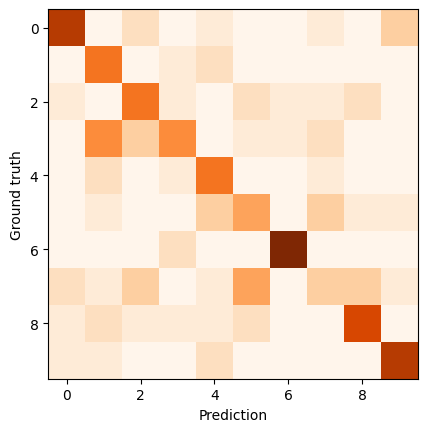

In [17]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Oranges);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

The model correctly predicts 51% of the instances, showing improvement over the previous result (32% accuracy). Class 9 has now higher values, even though the model still struggles with class 3 and 5.

**COMBO**-  Energy&ZCR

In [18]:
def combo3(signal):
    return np.concatenate((energy(signal),computezcr(signal)))

In [19]:

X_train, X_test, y_train, y_test = load_data(feature_extractor=combo3, normalize=True)


print('Number of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(np.array(X_train[0]).shape))




Number of training examples: 1350
Dimensionality of the training features: (2,)


In [20]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Training completed in 6.214s
Best parameters combination:
 C: 500
 gamma: 0.5


In [21]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.35      0.44        17
           1       0.23      0.70      0.35        10
           2       0.29      0.27      0.28        15
           3       0.43      0.16      0.23        19
           4       0.33      0.36      0.35        11
           5       0.35      0.50      0.41        14
           6       0.80      0.86      0.83        14
           7       0.10      0.05      0.07        19
           8       0.37      0.41      0.39        17
           9       0.31      0.29      0.30        14

    accuracy                           0.37       150
   macro avg       0.38      0.39      0.36       150
weighted avg       0.38      0.37      0.35       150



Confusion matrix:


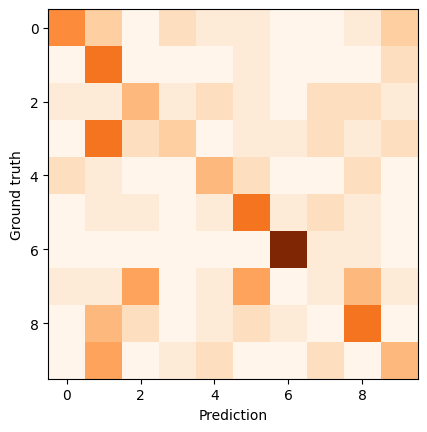

In [22]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Oranges);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

The model correctly predicts nearly aa third of the instances, it permormes well for some classes (6) and badly for others (7)

**COMBO**- Duration&ZCR

In [23]:
def combo4(signal):
    return np.concatenate((duration(signal),computezcr(signal)))

In [24]:

X_train, X_test, y_train, y_test = load_data(feature_extractor=combo4, normalize=True)


print('Number of training examples: {}'.format(len(X_train)))
print('Dimensionality of the training features: {}'.format(np.array(X_train[0]).shape))




Number of training examples: 1350
Dimensionality of the training features: (2,)


In [25]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Training completed in 3.196s
Best parameters combination:
 C: 500
 gamma: 0.5


In [26]:
# SVM test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.41      0.48        17
           1       0.37      0.70      0.48        10
           2       0.29      0.40      0.33        15
           3       0.38      0.16      0.22        19
           4       0.32      0.55      0.40        11
           5       0.07      0.07      0.07        14
           6       0.86      0.86      0.86        14
           7       0.18      0.16      0.17        19
           8       0.45      0.29      0.36        17
           9       0.57      0.57      0.57        14

    accuracy                           0.39       150
   macro avg       0.41      0.42      0.39       150
weighted avg       0.40      0.39      0.38       150



Confusion matrix:


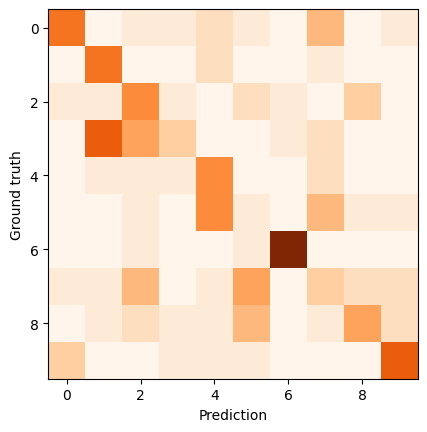

In [27]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Oranges);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

Classes like 6 and 9 have a good performance of the mdoel, other classes like 5 and 7 are problematic. Performance is however slightly better if compared with the previous combo.
